In [1]:
from multivp_dataset import MULTI_VP_Dataset
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from tqdm.notebook import tqdm
import datetime

from models.mad_gan import Generator, Discriminator
from tools.viz import plot_anomalies, plot_single_var, plot_to_tensorboard, plot_anomaly_scores, plot_train_hist
from tools.anomaly import madgan_reconstruction, madgan_reconstruction_discr_loss, feature_anomaly_score

time_id = datetime.datetime.now().strftime("%m%d-%H%M")

class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('../data/compiled/inputs.csv')
        self.batch_size = 32
        self.nworkers = 4
        self.shuffle = True
        self.drop_last = False
        self.method = "window_mag"
        self.nseqs = 4
        self.scaler = MinMaxScaler((-1,1))
        self.wsize = 5
        
        # Train params
        self.lr = 0.0001
        self.epochs = 25
        self.G_niters = 5
        self.D_niters = 10
        
        self.model_out = Path('./runs/multi/' + time_id + '_w20_madgan_pca320')
        self.train_plots = True

        # create ouput dirs
        if not self.model_out.exists(): self.model_out.mkdir(parents=True)
        
        (self.model_out / "img").mkdir(exist_ok=True)
        
opts = Options()


# Setup Training Dataset

In [2]:
dataset = MULTI_VP_Dataset(
    path=opts.data_path,
    method=opts.method,
    remove_extreme=True,
    is_train=True,
    scaler=opts.scaler,
    # nseqs=opts.nseqs
    window_size=opts.wsize,
    use_pca=True,
    pca_scaler=MinMaxScaler((-1,1)),
    n_components=128   
)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.nworkers, drop_last=False)

Removed 705 extreme values
Window size: 5
Window shape:  torch.Size([5, 128])
First window:
 tensor([[ 3.2176e-01, -4.2663e-01,  2.2099e-01, -2.5098e-02, -4.2099e-02,
         -6.6451e-01, -1.6003e-01, -5.0534e-01, -2.4341e-01, -1.5236e-01,
         -3.9254e-01, -2.1491e-01, -8.5607e-02, -5.3411e-02, -7.6194e-02,
         -2.3526e-01, -1.8713e-01, -3.2546e-02, -2.3555e-01, -7.0367e-01,
         -3.3448e-01, -5.7108e-02, -5.6203e-02, -1.7620e-01, -1.4149e-01,
         -4.9773e-02, -1.4797e-01, -2.2705e-01, -5.4293e-02, -2.4061e-01,
         -1.1997e-01, -1.7336e-01, -1.1563e-01, -1.2490e-01, -1.6875e-01,
         -4.3222e-01, -1.5218e-01, -1.9765e-01, -2.7059e-02, -3.7355e-01,
         -3.5790e-02, -6.6057e-03, -1.1522e-01, -1.1569e-01, -1.6973e-01,
         -7.0116e-02, -5.1677e-01, -1.0257e-01, -3.5205e-02, -1.9462e-01,
         -2.9690e-02, -5.6946e-02, -1.9391e-01, -2.8817e-01, -8.5916e-02,
         -3.9203e-01, -1.0368e-01, -3.0914e-03, -7.0158e-02, -2.9515e-01,
         -3.8952e-0

In [3]:
# dataset.plot(title="Magnetic Field")

# Models

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

netG = Generator(
    input_size=dataset.inputs.shape[1],
    hidden_size=100,
    output_size=dataset.inputs.shape[1],
    nlayers=3,
    dropout=0,
    bidirectional=False,
    arch='GRU',
).to(device)

netD = Discriminator(
    input_size=dataset.inputs.shape[1],
    hidden_size=100,
    nlayers=1,
    dropout=0.1,
    bidirectional=False,
    arch='GRU',
).to(device)

Using device:  cuda:0


/home/ivsaav/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [5]:
netG.train()

Generator(
  (rnn): GRU(128, 100, num_layers=3, batch_first=True)
  (linear): Linear(in_features=100, out_features=128, bias=True)
)

In [6]:
netD.train()

Discriminator(
  (rnn): GRU(128, 100, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [7]:
logger = SummaryWriter(f"logs/mad_gan_pca/{time_id}_D{netD.hidden_size}-L{netD.nlayers}_G{netG.hidden_size}-L{netG.nlayers}")
logger.add_graph(netG, torch.rand(opts.batch_size, opts.wsize, dataset.inputs.shape[1]).to(device))
logger.add_graph(netD, torch.rand(opts.batch_size,opts.wsize, dataset.inputs.shape[1]).to(device))
logger.add_text("Generator", netG.__str__())
logger.add_text("Discriminator", netD.__str__())

2023-03-15 11:45:31.045188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Training

In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

nseqs = opts.wsize

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=opts.lr)
optimizerG = optim.Adam(netG.parameters(), lr=opts.lr)

In [9]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0
best_loss = np.inf
best_loss_dist = np.inf

print("Starting Training Loop...")
# For each epoch
for epoch in range(opts.epochs):
    D_epoch_loss = 0
    G_epoch_loss = 0
    
    # For each batch in the dataloader
    for i, (x, _filename) in tqdm(enumerate(dataloader), desc=f"Epoch [{epoch}/{opts.epochs}]", total=len(dataloader), leave=False):
        
        # Format batch
        real = x.to(device)
        b_size, seq_len = real.size(0), real.size(1)
        real_labels = torch.full((b_size, nseqs, 1), real_label, dtype=torch.float, device=device)
        
        # Train discriminator network to maximize log(D(x)) + log(1 - D(G(z)))
        for _ in range(opts.D_niters):
            netD.zero_grad()
            
            # Train with real batch
            output = netD(real)
            errD_real = criterion(output, real_labels)
            errD_real.backward()
            
            # Train with fake batch
            fake = netG(torch.rand_like(real, device=device))
            fake_labels = torch.full((b_size, nseqs, 1), fake_label, dtype=torch.float, device=device)
            
            output = netD(fake.detach())
            errD_fake = criterion(output, fake_labels)
            errD_fake.backward()
            
            errD = errD_real + errD_fake
            optimizerD.step()
        D_losses.append(errD.item())
        
        # Train generator network to maximize log(D(G(z)))
        for _ in range(opts.G_niters):
            netG.zero_grad()
            
            fake = netG(torch.rand_like(real, device=device))
            output = netD(fake)
            errG = criterion(output, real_labels)
            errG.backward()
            optimizerG.step()
        G_losses.append(errG.item())
        # send losses to tensorboard
        logger.add_scalars('Loss/train', {'G': errG.item(), 'D': errD.item()}, iters)
        iters += 1
        
    # Calculate epoch losses
    output = netD(real)
    errD_real = criterion(output, real_labels)
    D_x = output.mean().item()
    
    fake = netG(torch.rand_like(real, device=device)).detach()
    output = netD(fake)
    errD_fake = criterion(output, fake_labels)
    D_G_z1 = output.mean().item()
    
    errD = errD_real + errD_fake
    errG = criterion(output, real_labels)

    # Output training stats
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
            % (epoch, opts.epochs,
                errD.item(), errG.item(), D_x, D_G_z1))

    # save best model if total loss is better than last 
    # and distance between losses is better than last (model convergence)
    if abs(errD-errG).item() < best_loss_dist and epoch > 2 and D_x > 0.7: 
        best_loss_dist = torch.abs(errD-errG).item()
        torch.save(netG.state_dict(), opts.model_out / 'Gbest.pth')
        torch.save(netD.state_dict(), opts.model_out / 'Dbest.pth')
        
        if opts.train_plots:
            # fake = dataset.unscale(fake.detach().cpu().numpy())
            fake = dataset.flatten(fake.detach().cpu().numpy())
            fig = plot_single_var(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scale="linear")
            fig.savefig(opts.model_out / f"img/{epoch}_best", dpi=200)
            plot_to_tensorboard(logger, fig, epoch, "train/best")
            plt.close(fig)
    elif epoch % 5 == 0:
        torch.save(netG.state_dict(), opts.model_out / f'G{epoch}.pth')
        torch.save(netD.state_dict(), opts.model_out / f'D{epoch}.pth')
        
        if opts.train_plots:
            fake = dataset.flatten(fake.detach().cpu().numpy())
            # fake = dataset.unscale(fake.detach().cpu().numpy())
            fig = plot_single_var(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scale="linear")
            fig.savefig(opts.model_out / f'img/inter_{epoch}.png', dpi=200)
            plot_to_tensorboard(logger, fig, epoch, "train/inter")
            plt.close(fig)
            
        train_f = plot_train_hist(D_losses, G_losses, opts.model_out)
        plt.close(train_f)
    

Starting Training Loop...


Epoch [0/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[0/25]	Loss_D: 0.2314	Loss_G: 2.0758	D(x): 0.9710	D(G(z)): 0.1717


Epoch [1/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[1/25]	Loss_D: 0.2672	Loss_G: 2.5452	D(x): 0.9205	D(G(z)): 0.1499


Epoch [2/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[2/25]	Loss_D: 1.0252	Loss_G: 0.6927	D(x): 0.7576	D(G(z)): 0.5077


Epoch [3/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[3/25]	Loss_D: 2.2480	Loss_G: 0.2257	D(x): 0.6840	D(G(z)): 0.8050


Epoch [4/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[4/25]	Loss_D: 1.6266	Loss_G: 0.4488	D(x): 0.5936	D(G(z)): 0.6469


Epoch [5/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[5/25]	Loss_D: 1.7452	Loss_G: 0.4222	D(x): 0.5732	D(G(z)): 0.6673


Epoch [6/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[6/25]	Loss_D: 1.7793	Loss_G: 0.4394	D(x): 0.5146	D(G(z)): 0.6477


Epoch [7/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[7/25]	Loss_D: 1.4158	Loss_G: 0.5541	D(x): 0.6048	D(G(z)): 0.5813


Epoch [8/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[8/25]	Loss_D: 1.3598	Loss_G: 0.6064	D(x): 0.5818	D(G(z)): 0.5476


Epoch [9/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[9/25]	Loss_D: 1.7948	Loss_G: 0.3705	D(x): 0.5524	D(G(z)): 0.6922


Epoch [10/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[10/25]	Loss_D: 1.3419	Loss_G: 0.6098	D(x): 0.6058	D(G(z)): 0.5451


Epoch [11/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[11/25]	Loss_D: 1.7904	Loss_G: 0.4083	D(x): 0.5961	D(G(z)): 0.6756


Epoch [12/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[12/25]	Loss_D: 1.4228	Loss_G: 0.5490	D(x): 0.6101	D(G(z)): 0.5816


Epoch [13/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[13/25]	Loss_D: 1.7047	Loss_G: 0.5299	D(x): 0.5643	D(G(z)): 0.5939


Epoch [14/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[14/25]	Loss_D: 0.0390	Loss_G: 3.5656	D(x): 0.9918	D(G(z)): 0.0300


Epoch [15/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[15/25]	Loss_D: 0.4663	Loss_G: 1.0607	D(x): 0.9882	D(G(z)): 0.3573


Epoch [16/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[16/25]	Loss_D: 0.1413	Loss_G: 2.4685	D(x): 0.9891	D(G(z)): 0.1166


Epoch [17/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[17/25]	Loss_D: 0.0116	Loss_G: 4.8380	D(x): 0.9986	D(G(z)): 0.0101


Epoch [18/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[18/25]	Loss_D: 0.0025	Loss_G: 6.4733	D(x): 0.9994	D(G(z)): 0.0019


Epoch [19/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[19/25]	Loss_D: 0.0001	Loss_G: 17.3614	D(x): 0.9999	D(G(z)): 0.0000


Epoch [20/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[20/25]	Loss_D: 0.0051	Loss_G: 6.3457	D(x): 0.9999	D(G(z)): 0.0050


Epoch [21/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[21/25]	Loss_D: 0.0006	Loss_G: 8.1542	D(x): 0.9999	D(G(z)): 0.0005


Epoch [22/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[22/25]	Loss_D: 0.0001	Loss_G: 12.4311	D(x): 1.0000	D(G(z)): 0.0000


Epoch [23/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[23/25]	Loss_D: 0.1585	Loss_G: 5.0555	D(x): 0.9357	D(G(z)): 0.0738


Epoch [24/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[24/25]	Loss_D: 1.2572	Loss_G: 0.6325	D(x): 0.6284	D(G(z)): 0.5361


In [10]:
logger.flush()

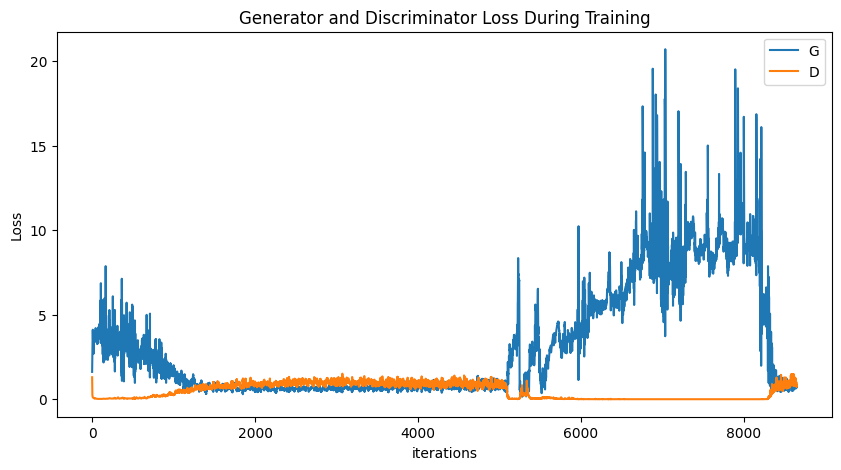

In [11]:
fig = plot_train_hist(D_losses, G_losses, opts.model_out)

# Plot Random Generated Inputs

In [12]:
# # load best model
# netG.load_state_dict(torch.load(opts.model_out / 'G.pth'))

In [13]:
# lines = []

# # generate random samples
# for i in range(100):
#     noise = torch.randn_like(real, device=device)
#     fake, _ = netG(noise)
#     fake = fake.flatten(end_dim=1).detach().cpu().numpy()
#     lines.append(fake)


# inv_fake_data = dataset.unscale(np.array(lines))
# # inv_fake_data = pd.DataFrame(inv_fake_data)

In [14]:
# plot_data_values(inv_fake_data, "Random Generated", label="B [G]", scale="log")

# Anomaly Detection

In [15]:

netD.train(True)
netG.train(True)

class AnomalyParams:
    batch_size = 128
    models_dir = opts.model_out
    # models_dir = Path("./runs/multi/0313-1135_w20_madgan_pca320")
    # reconstruction based
    niter = 100 # number of iterations for reconstruction
    lambda_thresh = 0.1
    lr = 1e-2
    
opts_eval = AnomalyParams()

# load best models
netG.load_state_dict(torch.load(opts_eval.models_dir / 'G10.pth'))
netD.load_state_dict(torch.load(opts_eval.models_dir / 'D10.pth'))

<All keys matched successfully>

In [16]:
eval_dataset = MULTI_VP_Dataset._from(dataset)
# eval_dataset = MULTI_VP_Dataset(opts.data_path, method=opts.method, scaler=opts.scaler, window_size=10, pca=True, n_components=opts.n_components)
eval_dataloader = DataLoader(eval_dataset, batch_size=opts_eval.batch_size, shuffle=False, num_workers=opts.nworkers)

Window size: 5
Window shape:  torch.Size([5, 128])
First window:
 tensor([[ 3.2176e-01, -4.2663e-01,  2.2099e-01, -2.5098e-02, -4.2099e-02,
         -6.6451e-01, -1.6003e-01, -5.0534e-01, -2.4341e-01, -1.5236e-01,
         -3.9254e-01, -2.1491e-01, -8.5607e-02, -5.3411e-02, -7.6194e-02,
         -2.3526e-01, -1.8713e-01, -3.2546e-02, -2.3555e-01, -7.0367e-01,
         -3.3448e-01, -5.7108e-02, -5.6203e-02, -1.7620e-01, -1.4149e-01,
         -4.9773e-02, -1.4797e-01, -2.2705e-01, -5.4293e-02, -2.4061e-01,
         -1.1997e-01, -1.7336e-01, -1.1563e-01, -1.2490e-01, -1.6875e-01,
         -4.3222e-01, -1.5218e-01, -1.9765e-01, -2.7059e-02, -3.7355e-01,
         -3.5790e-02, -6.6057e-03, -1.1522e-01, -1.1569e-01, -1.6973e-01,
         -7.0116e-02, -5.1677e-01, -1.0257e-01, -3.5205e-02, -1.9462e-01,
         -2.9690e-02, -5.6946e-02, -1.9391e-01, -2.8817e-01, -8.5916e-02,
         -3.9203e-01, -1.0368e-01, -3.0914e-03, -7.0158e-02, -2.9515e-01,
         -3.8952e-01, -8.0182e-02, -8.6872e-02

## Discriminator Classification

In [17]:
scores = []
# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    outputs = netD(x.to(device))
    # calculate mean classification score for each sample
    for sample, filename in zip(outputs, filenames):
        # print(sample, filename)
        class_avg = sample[0]
        scores.append((filename, 1-class_avg.item()))

Anomaly Threshold:  0.5948314666748047
Found 1176 anomalies


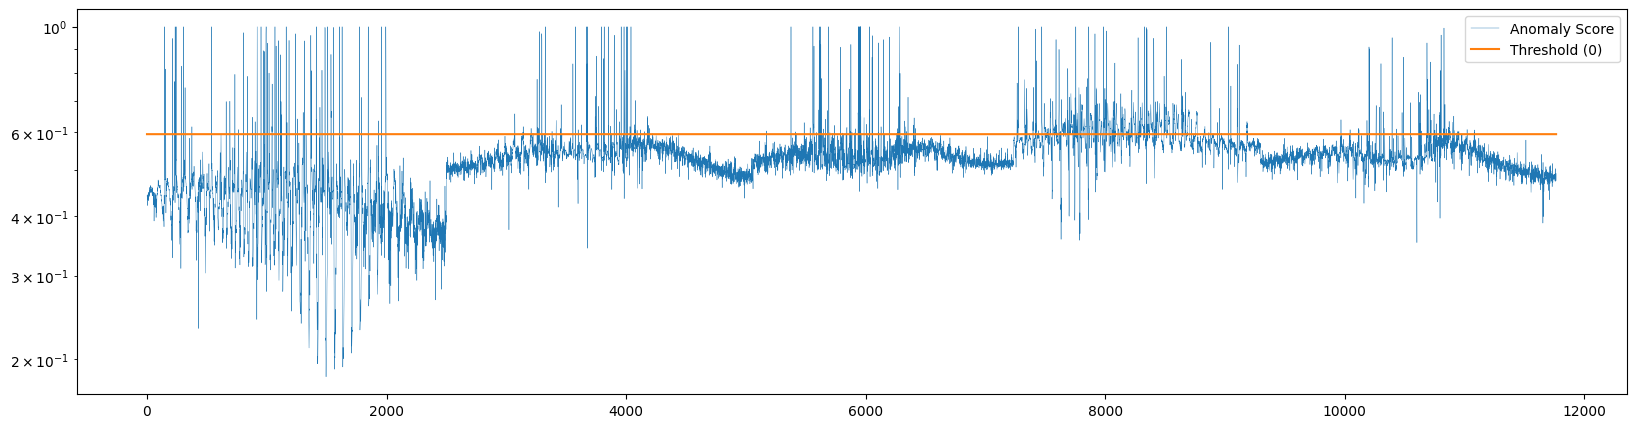

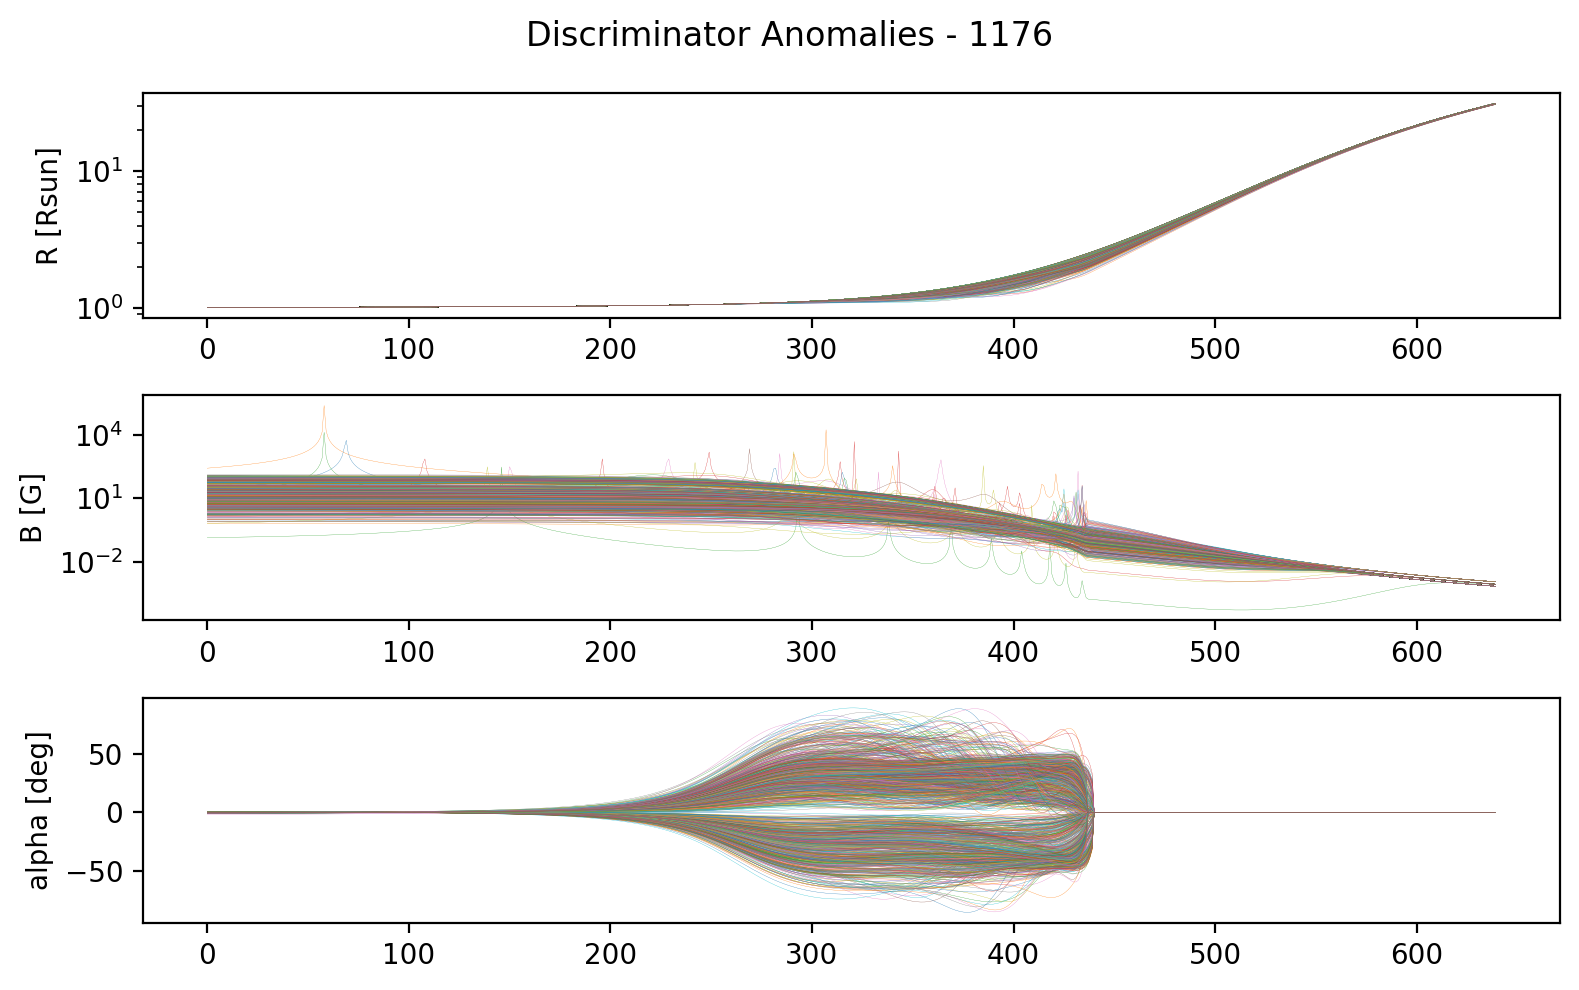

In [18]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/discr_scores",
                        scale="log", method="Discriminator", logger=logger, logger_var="test/discr")

## Reconstruction Based

In [19]:
def reconstruction_anomaly_scores(dataloader, netG : nn.Module, netD : nn.Module, device : str,
                                  max_iters=100, reconstr_fn=madgan_reconstruction):
    mse_scores = []
    for i, (x, filenames) in enumerate(dataloader, 0):
        _z, loss = reconstr_fn(x, netG, netD, device, max_iters)
        mse_scores.extend(zip(filenames, [l.sum(-1).detach().cpu().numpy()[0] for l in loss]))
        print(f"[{i}/{len(dataloader)}]", end='\r', flush=True)
        
    return mse_scores

### MSE Reconstruction

In [20]:
reconstr_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device, opts_eval.niter, madgan_reconstruction)

Anomaly Threshold:  2.3549716
Found 1176 anomalies


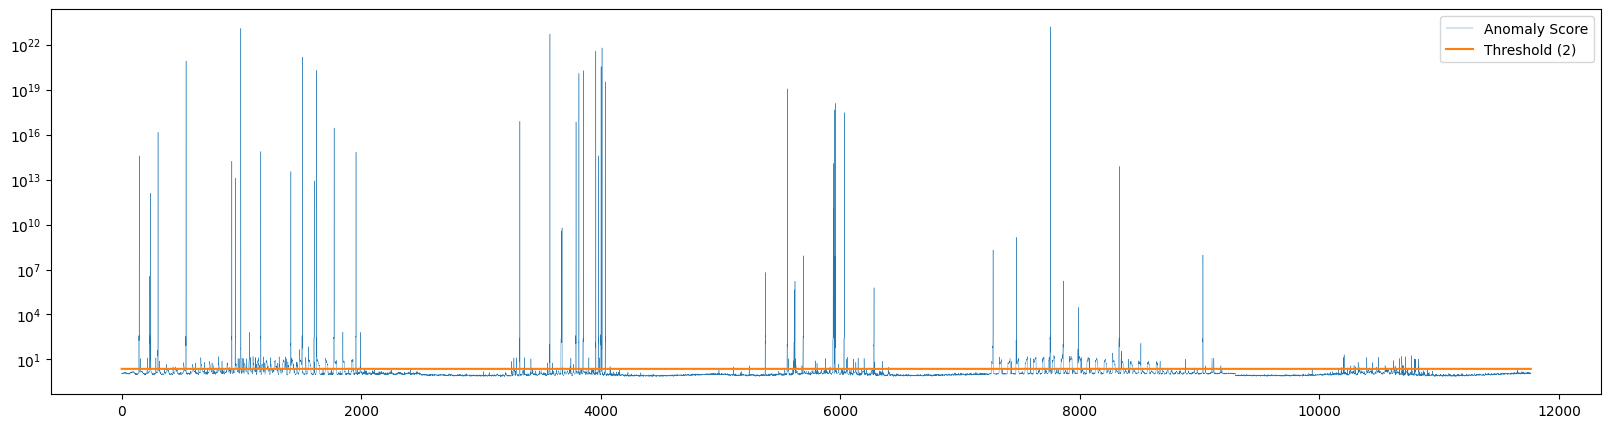

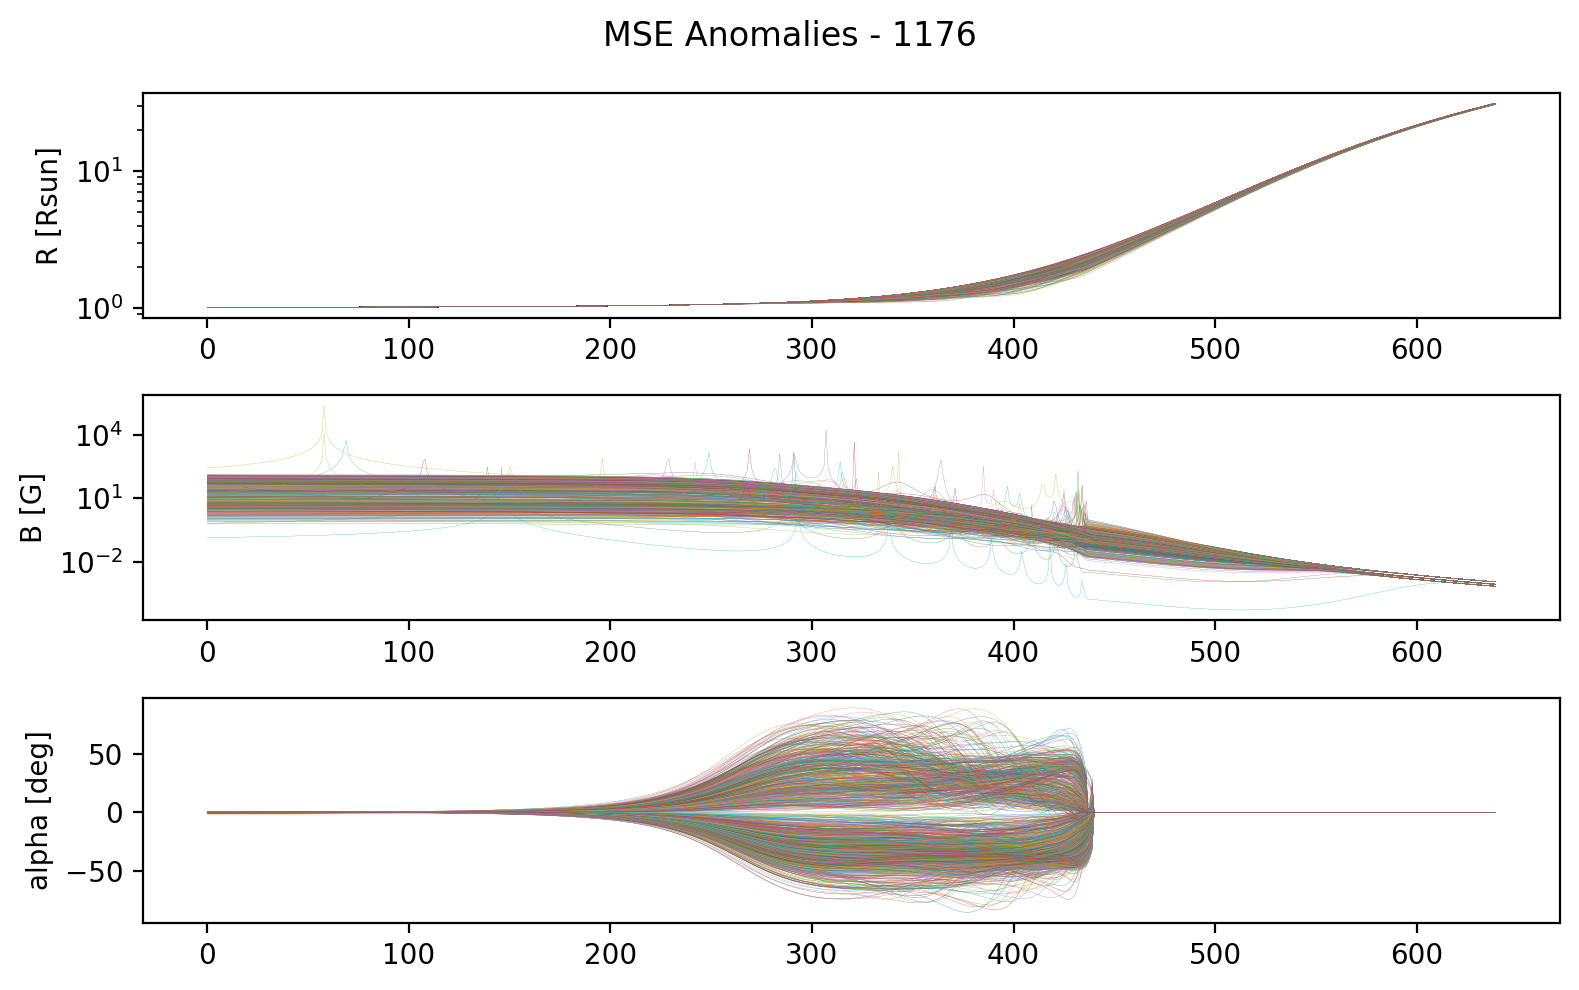

In [21]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/mse", 
                        scale="log", method="MSE", logger=logger, logger_var="test/mse")

### MSE Reconstruction with Discriminator feedback

In [22]:
reconstr_scores_discr = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                      opts_eval.niter, madgan_reconstruction_discr_loss)

Anomaly Threshold:  0.02853531
Found 1176 anomalies


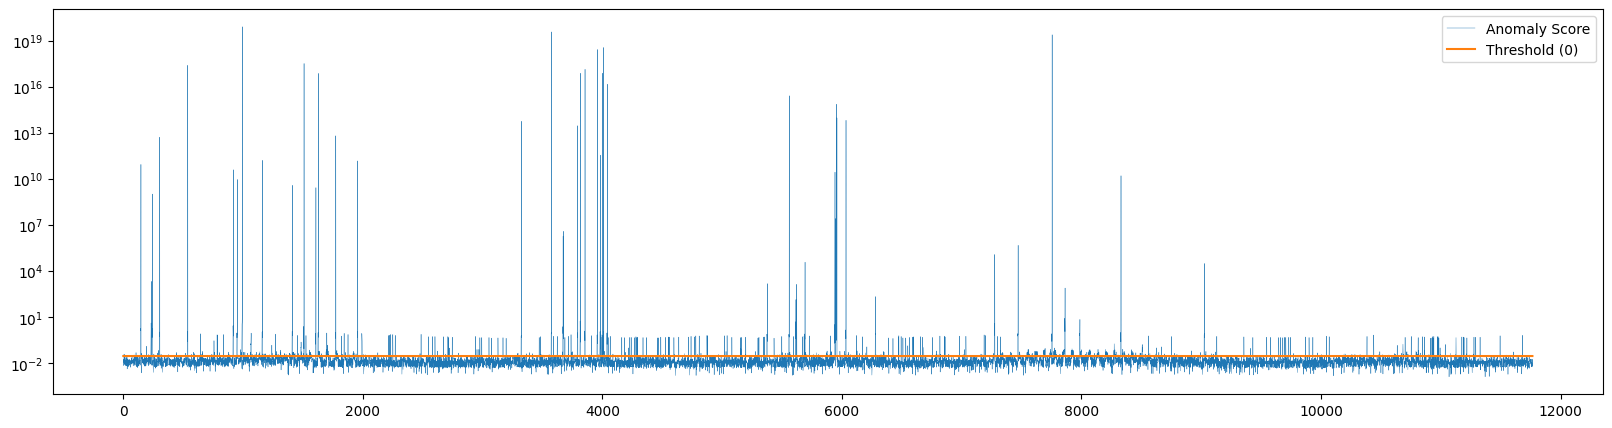

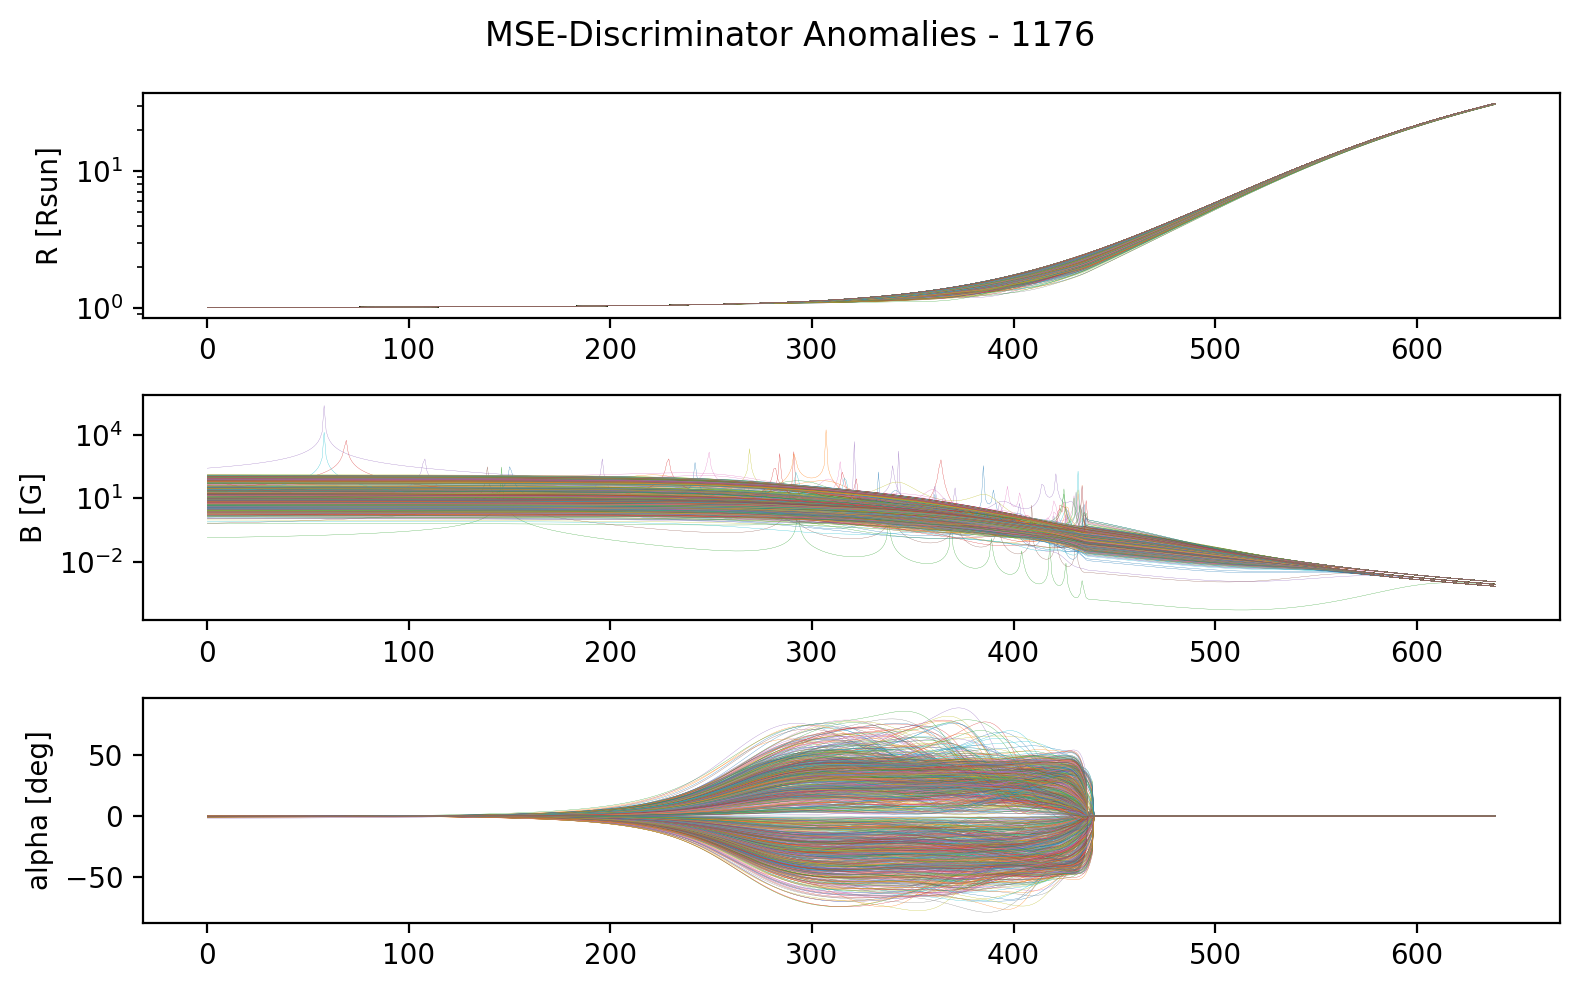

In [23]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_scores_discr, 0.1, opts.data_path, opts_eval.models_dir /  f"img/mse_discr",
                        scale="log", method="MSE-Discriminator", logger=logger, logger_var="test/mse_discr")

### Feature Reconstruction

In [24]:
reconstr_feature_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                        opts_eval.niter, madgan_reconstruction_discr_loss)

Anomaly Threshold:  0.0279986
Found 1176 anomalies


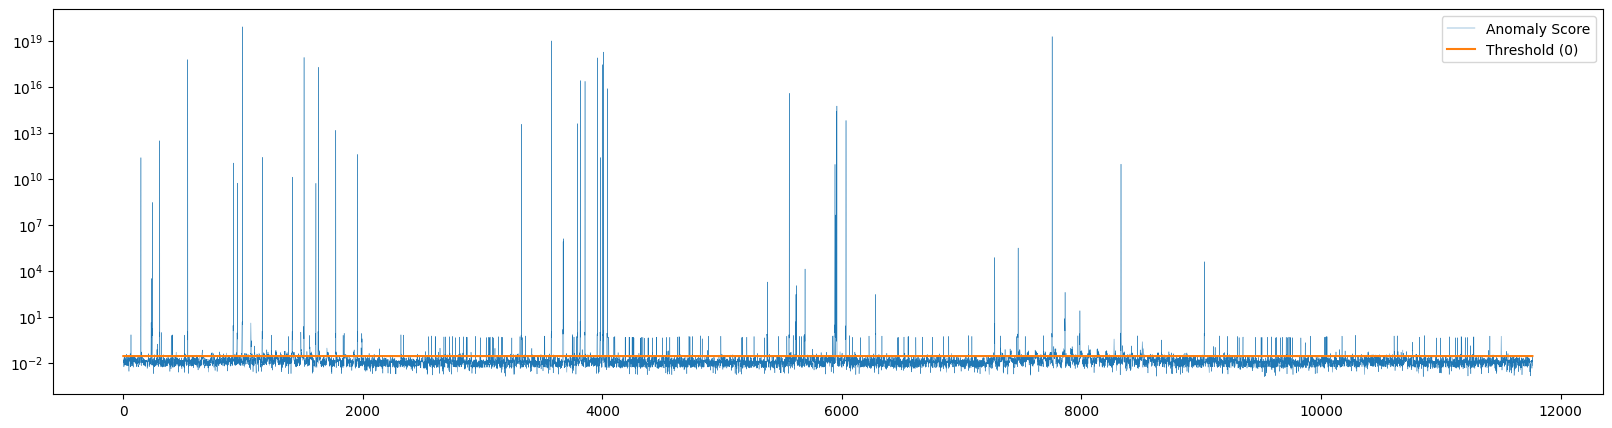

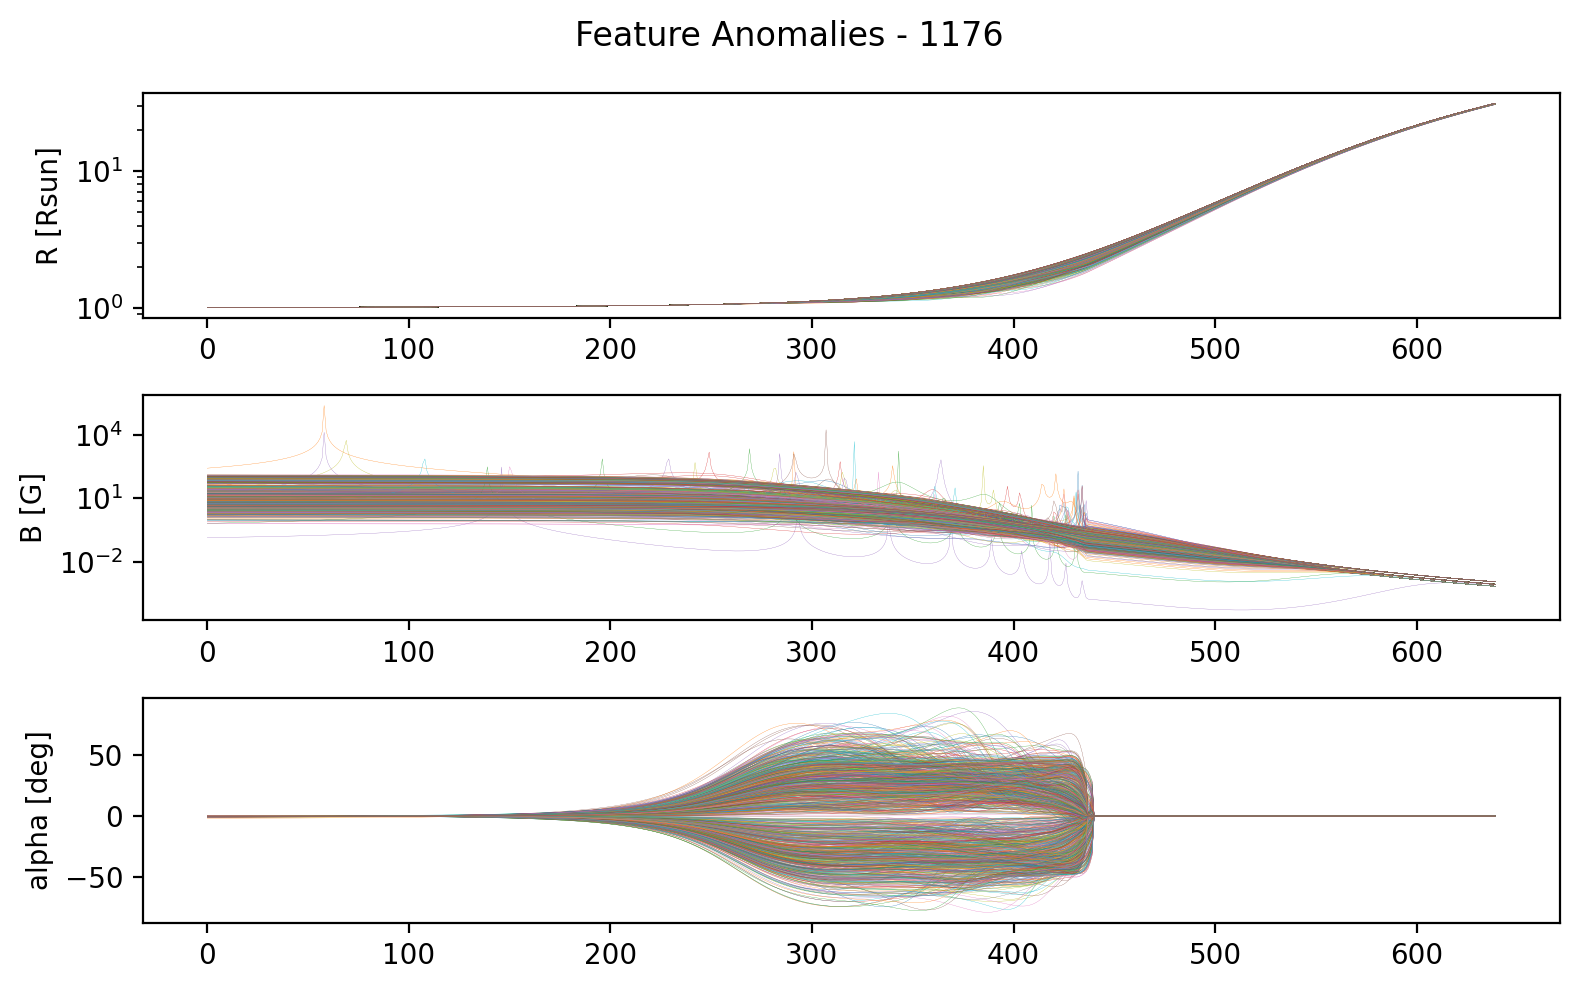

In [25]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_feature_scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/mse_feature",
                        scale="log", method="Feature", logger=logger, logger_var="test/mse_feature")

In [26]:
logger.flush()